In [0]:
import tensorflow.keras
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#get training and validaiton images

train_faces = 'gdrive/My Drive/MSc/Computer Vision/train_faces_color'

val_faces = 'gdrive/My Drive/MSc/Computer Vision/val_faces_color'

In [0]:
#check one image
img = cv2.imread(f'{train_faces}/66/face1.jpg')

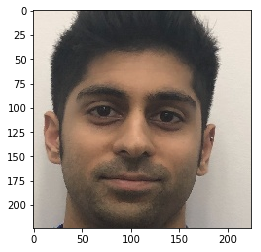

In [0]:
#display test image
plt.imshow(img)

In [0]:
#create data generator to prepare images for training
datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=False,
        )

In [0]:
#data generator for training images
train_generator = datagen.flow_from_directory(
train_faces,
target_size=(224, 224),
color_mode='rgb',
batch_size=32,
class_mode='categorical')

Found 796 images belonging to 69 classes.


In [0]:
#data generator for validation images
val_generator = datagen.flow_from_directory(
val_faces,
target_size=(224, 224),
color_mode='rgb',
batch_size=32,
class_mode='categorical')

Found 148 images belonging to 69 classes.


In [0]:
#load pre-trained VGG16
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 1s 0us/step


In [0]:
#below snippet left in for testing purposes. Uncomment if you want to unfreeze some vgg layers
# # Freeze the layers except the last 4 layers
# for layer in vgg_conv.layers[:-4]:
#     layer.trainable = False
        
# Freeze all layers
for layer in vgg_conv.layers:
    layer.trainable = False
 
# Check that layers are frozen
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f12922cc048> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f123f6ab3c8> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f123f6dc0b8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f123b67cfd0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f123f6dc898> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f123b69aba8> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f123c622320> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f123c691b00> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f123c641da0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f123c5f4390> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f124983d978> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

In [0]:
# Create the model
model = Sequential()
 
# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(69, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 69)                70725     
Total params: 40,476,549
Trainable params: 25,761,861
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
#compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#stop training early is validation loss starts decreasing
early_stopping_monitor = EarlyStopping(patience=2)

In [0]:
#train model
model.fit(train_generator, validation_data=val_generator, epochs=30, batch_size=32, callbacks=[early_stopping_monitor])

Epoch 1/30
25/25 [==============================] - 13s 533ms/step - loss: 0.1563 - acc: 0.9673 - val_loss: 0.2670 - val_acc: 0.9392
Epoch 2/30
25/25 [==============================] - 12s 462ms/step - loss: 0.1030 - acc: 0.9849 - val_loss: 0.2382 - val_acc: 0.9392
Epoch 3/30
25/25 [==============================] - 11s 446ms/step - loss: 0.0825 - acc: 0.9862 - val_loss: 0.2784 - val_acc: 0.9257
Epoch 4/30
25/25 [==============================] - 11s 444ms/step - loss: 0.0768 - acc: 0.9862 - val_loss: 0.2663 - val_acc: 0.9324
CPU times: user 55.7 s, sys: 2.34 s, total: 58 s
Wall time: 47.2 s


In [0]:
#save model
model.save('gdrive/My Drive/MSc/Computer Vision/vgg16_cnn.h5')